In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as shc 

In [3]:
# Load your data into a DataFrame
df = pd.read_csv('features.csv')

df['first_sale_date'] = pd.to_datetime(df['first_sale_date'], errors='coerce')
df['last_sale_date'] = pd.to_datetime(df['last_sale_date'], errors='coerce')
df['first_stock_date'] = pd.to_datetime(df['first_stock_date'], errors='coerce')

df['fsd_year'] = df['first_sale_date'].dt.year
df['fsd_month'] = df['first_sale_date'].dt.month
df['fsd_day'] = df['first_sale_date'].dt.day

df['lsd_year'] = df['last_sale_date'].dt.year
df['lsd_month'] = df['last_sale_date'].dt.month
df['lsd_day'] = df['last_sale_date'].dt.day

df['fstd_year'] = df['first_stock_date'].dt.year
df['fstd_month'] = df['first_stock_date'].dt.month
df['fstd_day'] = df['first_stock_date'].dt.day

df = df.drop(columns=['first_stock_date','last_sale_date','first_sale_date'])

# Drop columns that only contain NaN values
df = df.dropna(axis=1, how='all')
df = df.drop(df.columns[0], axis=1)

In [4]:
nan_counts = df.isna().sum()

In [5]:
df.describe(include= np.number).columns

Index(['id', 'location_id', 'primary_vendor_id', 'weight', 'volume',
       'sale_price', 'importance_id', 'qty_per_purchase_unit', 'stock_units',
       'stock_price', 'undelivered', 'forc_uncertainty', 'moq_days',
       'sale_qty_last_3_months', 'sale_value_last_3_months',
       'sale_value_last_6_months', 'sale_qty_last_6_months',
       'sale_value_last_12_months', 'sale_qty_last_12_months', 'stock_volume',
       'overstocked_units', 'service_level_last_30_days', 'confidence_factor',
       'order_frequency_days', 'additional_lead_time_days', 'reorder_point',
       'min_stock', 'min_order', 'cost_price', 'purchase_price',
       'order_multiple_in_base_units', 'lead_time_days', 'qty_pallet',
       'replenishment_type', 'fsd_year', 'fsd_month', 'fsd_day', 'lsd_year',
       'lsd_month', 'lsd_day', 'fstd_year', 'fstd_month', 'fstd_day'],
      dtype='object')

In [6]:
df[['forc_uncertainty', 'moq_days', 'confidence_factor', 'purchase_price', 'qty_pallet']]

,forc_uncertainty,moq_days,confidence_factor,purchase_price,qty_pallet
0,0.0,NaN,60.0,95.00,NaN
1,0.0,NaN,50.0,43.00,NaN
2,62.0,0.0,85.0,67.50,36.0
3,0.0,NaN,50.0,126.00,NaN
4,59.0,69.0,85.0,6.64,576.0
...,...,...,...,...,...
19220,0.0,365.0,60.0,0.00,936.0
19221,0.0,365.0,60.0,0.00,936.0
19222,0.0,365.0,60.0,3150.00,NaN
19223,0.0,365.0,60.0,3150.00,NaN


In [7]:
df.describe(include= np.object_).columns
nan_counts[nan_counts > 0].index.tolist()

['forc_uncertainty',
 'moq_days',
 'confidence_factor',
 'purchase_price',
 'qty_pallet',
 'fsd_year',
 'fsd_month',
 'fsd_day',
 'lsd_year',
 'lsd_month',
 'lsd_day',
 'fstd_year',
 'fstd_month',
 'fstd_day']

In [8]:
df[['fsd_year', 'fsd_month', 'fsd_day', 'lsd_year', 'lsd_month', 'lsd_day', 'fstd_year', 'fstd_month', 'fstd_day']] = df[['fsd_year', 'fsd_month', 'fsd_day', 'lsd_year', 'lsd_month', 'lsd_day', 'fstd_year', 'fstd_month', 'fstd_day']].fillna(0)


columns_to_fill = ['forc_uncertainty', 'moq_days', 'confidence_factor', 'purchase_price', 'qty_pallet']

# Fill NaN values in specific columns with their mean
df[['forc_uncertainty', 'moq_days', 'confidence_factor', 'purchase_price', 'qty_pallet']] = df[['forc_uncertainty', 'moq_days', 'confidence_factor', 'purchase_price', 'qty_pallet']].fillna(df[['forc_uncertainty', 'moq_days', 'confidence_factor', 'purchase_price', 'qty_pallet']].median())


In [9]:
# Identify numerical and categorical columns
numerical_features = ['id', 'location_id', 'primary_vendor_id', 'weight', 'volume',
       'sale_price', 'importance_id', 'qty_per_purchase_unit', 'stock_units',
       'stock_price', 'undelivered', 'forc_uncertainty', 'moq_days',
       'sale_qty_last_3_months', 'sale_value_last_3_months',
       'sale_value_last_6_months', 'sale_qty_last_6_months',
       'sale_value_last_12_months', 'sale_qty_last_12_months', 'stock_volume',
       'overstocked_units', 'service_level_last_30_days', 'confidence_factor',
       'order_frequency_days', 'additional_lead_time_days', 'reorder_point',
       'min_stock', 'min_order', 'cost_price', 'purchase_price',
       'order_multiple_in_base_units', 'lead_time_days', 'qty_pallet',
       'replenishment_type', 'fsd_year', 'fsd_month', 'fsd_day', 'lsd_year',
       'lsd_month', 'lsd_day', 'fstd_year', 'fstd_month', 'fstd_day']
categorical_features = ['NAME', 'chart_label', 'abc_grouping']



In [10]:
# Make sure the features exist in the DataFrame after dropping NaN columns
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]

# Define transformers
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

In [11]:
# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply transformations
X = preprocessor.fit_transform(df)

Number of components needed to explain 95% of the variance: 27


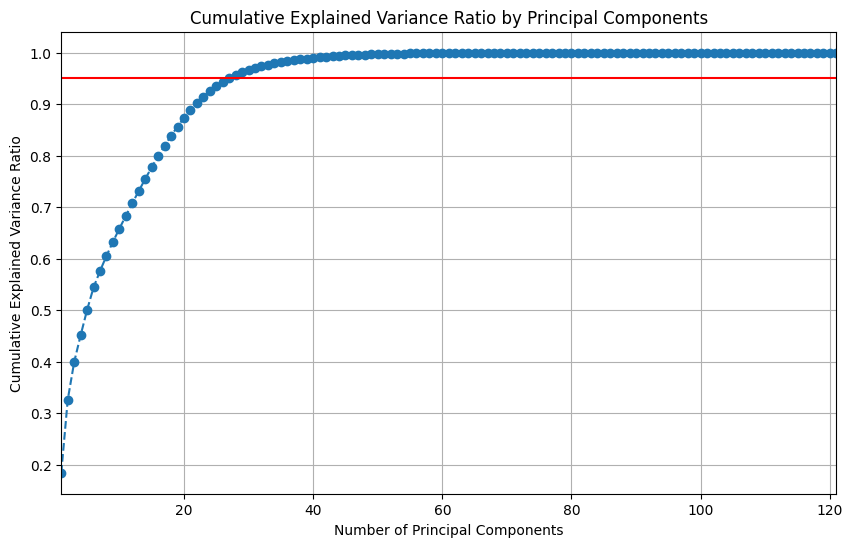

In [17]:
# Apply PCA
pca = PCA()
X_PCA = pca.fit_transform(X)

# Find the index where cumulative explained variance ratio first exceeds or equals 95%
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
n_components_95 = next(i for i, ratio in enumerate(cumulative_variance_ratio, 1) if ratio >= 0.95)

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)

# Draw a horizontal line at 95% cumulative explained variance ratio
plt.axhline(y=0.95, color='r', linestyle='-')

# Adjust x-axis limits for better readability
plt.xlim(1, len(cumulative_variance_ratio))

# Print the number of components needed to explain 95% of the variance
print(f"Number of components needed to explain 95% of the variance: {n_components_95}")

plt.show()

In [23]:
pca = PCA(n_components = 27) 
X_principal = pca.fit_transform(X) 
X_principal = pd.DataFrame(X_principal) 

X_principal.columns = [f'P{i}' for i in range(1, 28)]
X_principal.columns

Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21',
       'P22', 'P23', 'P24', 'P25', 'P26', 'P27'],
      dtype='object')

In [27]:
X_principal

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27
0,2.089010,-0.400791,1.403380,1.799417,-0.191005,0.012452,0.502348,0.634124,-0.001157,-0.744985,...,-1.091449,-0.588149,0.611772,-0.948390,0.011455,-1.335068,-1.265133,-0.123476,0.221623,1.440629
1,1.915655,-0.438720,1.333185,1.094728,-0.888621,0.026597,-0.096148,0.744722,-0.158100,-0.822768,...,-0.223721,-0.214088,0.744807,-0.733614,-0.210744,-1.140500,0.263094,-0.499867,-0.246492,0.028487
2,1.666757,1.620533,1.104386,1.446454,-0.391221,-0.151741,1.154349,0.646946,0.555541,0.423236,...,0.433054,-0.601906,0.946649,-0.411323,0.372710,-1.037662,-0.312096,-0.316012,0.295165,-0.057081
3,2.159748,-0.457229,1.357029,2.199038,-0.052680,0.047123,0.122843,0.778950,-0.129747,-0.840733,...,-0.716668,-0.992891,0.972463,0.249487,-0.106131,-0.910315,0.568380,-0.452518,0.671731,-0.648784
4,1.100090,0.560760,1.958622,0.152056,-0.541958,-0.155012,1.552726,-0.205546,0.630545,-0.217242,...,-0.051720,0.533176,-0.589522,0.396974,0.521876,-0.986496,-0.032312,-0.316937,0.065590,-0.150298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19220,-5.518284,0.829215,1.683195,-0.271757,-1.120951,-0.144171,0.068623,-0.572937,0.201679,0.019113,...,0.018892,-0.301051,0.014639,-0.125203,0.125206,1.416038,-0.259685,-2.109770,0.478168,0.384799
19221,-6.170036,0.649740,-0.638025,-0.914878,0.041291,0.038098,0.001998,-0.377046,0.008430,0.030585,...,-0.139814,-0.244899,0.067967,-0.034695,0.033658,1.033035,-0.022281,-0.382497,0.157941,0.208641
19222,-4.074653,0.551243,1.168456,0.075762,-0.663599,-0.126783,-0.362286,-0.978746,0.008645,-0.077479,...,-0.424084,0.367339,-0.637011,-1.502868,0.080496,0.749084,-0.836869,-2.453039,0.398512,-1.064500
19223,-6.041447,0.689560,-0.081503,-0.441390,-0.025058,-0.016792,-0.188565,-0.984232,0.086879,0.045366,...,-0.174885,-0.175529,0.073377,-0.079853,0.053836,1.070952,-0.123831,-1.066684,0.319928,0.288795


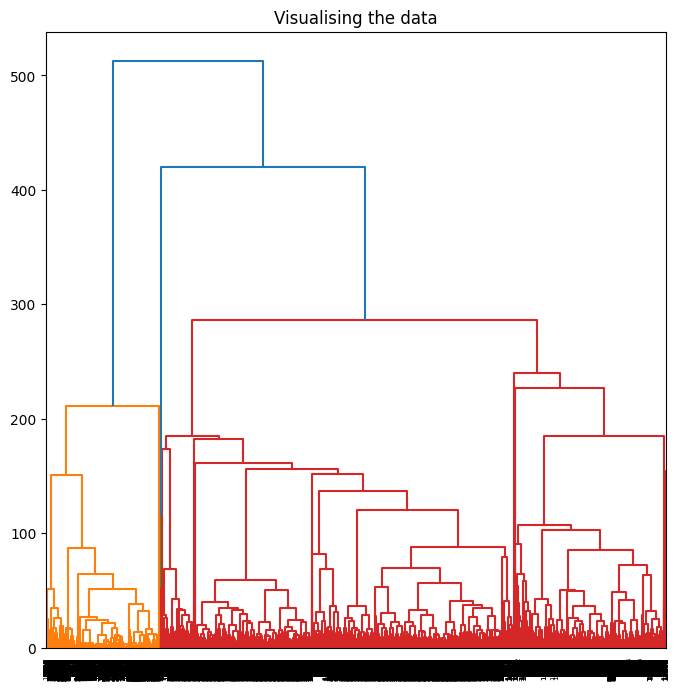

In [24]:



plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X_principal, method ='ward'))) 

In [29]:
from sklearn.cluster import AgglomerativeClustering 
ac2 = AgglomerativeClustering(n_clusters = 4) 
  
# Visualizing the clustering 
plt.figure(figsize =(6, 6)) 
plt.scatter(X_principal['P1'], X_principal['P2'], X_principal['P3'], X_principal['P4'], X_principal['P5'], X_principal['P6'], X_principal['P7'], X_principal['P8'], X_principal['P8'],
            X_principal['P9'], X_principal['P10'], X_principal['P11'], X_principal['P12'], X_principal['P13'], X_principal['P14'], X_principal['P15'], X_principal['P16'], 
            X_principal['P17'], X_principal['P18'], X_principal['P19'], X_principal['P20'], X_principal['P21'], X_principal['P22'], X_principal['P23'], X_principal['P24'],
            X_principal['P25'], X_principal['P26'], X_principal['P27'],
           c = ac2.fit_predict(X_principal), cmap ='rainbow') 
plt.show() 

TypeError: scatter() got multiple values for argument 'c'

<Figure size 600x600 with 0 Axes>

KeyboardInterrupt: 

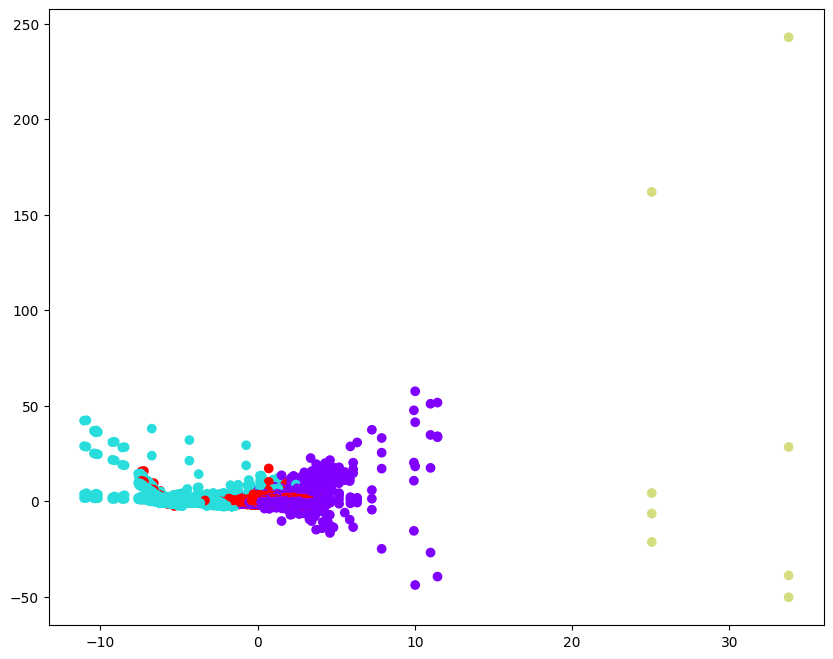

In [32]:
# Concatenate all PC columns into a single DataFrame
# Visualizing the clustering 
plt.figure(figsize=(10, 8))

# Plot the first 27 principal components
for i in range(1, 28):
    for j in range(i + 1, 28):
        plt.scatter(X_principal[f'P{i}'], X_principal[f'P{j}'], c=ac2.fit_predict(X_principal), cmap='rainbow')
plt.xlabel(f'Principal Component {i}')
plt.ylabel(f'Principal Component {j}')
plt.title(f'Clustering based on PC{i} and PC{j}')
plt.show()

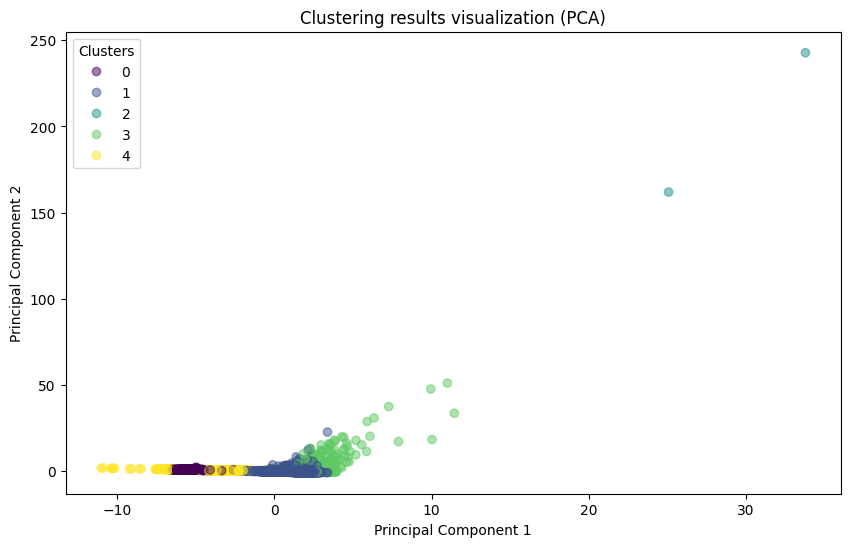

In [12]:
# Apply transformations
X = preprocessor.fit_transform(df)

# KPrototypes expects the categorical columns to be specified
categorical_indices = [df.columns.get_loc(col) for col in categorical_features]

# Apply K-Prototypes clustering
kproto = KPrototypes(n_clusters=5, random_state=42)
clusters = kproto.fit_predict(X, categorical=categorical_indices)

# Add cluster labels to the original DataFrame
df['Cluster'] = clusters

# PCA for dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot of the PCA-reduced data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering results visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()



In [ ]:
import scipy.cluster.hierarchy as shc 

In [13]:

sns.pairplot(df, hue='Cluster', palette='viridis')
plt.show()

# Cluster profile visualization
cluster_profile = df.groupby('Cluster').mean().T
cluster_profile.plot(kind='bar', figsize=(14, 8))
plt.title('Cluster Profiles')
plt.ylabel('Mean Value')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()